In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

# matplotlib
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Circle
import matplotlib.dates as mdates
%matplotlib inline

import datetime

import contextily as cx

import seaborn as sns
import os
from tqdm import tqdm

import shapely
from shapely.geometry import LineString, Point
from collections import Counter

import iteround

from sklearn.neighbors import KDTree
import importlib

/cluster/apps/nss/gcc-6.3.0/python/3.8.5/x86_64/lib64/python3.8/site-packages/pyproj/__init__.py:78: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [2]:
import utils
importlib.reload(utils)
import plotting_utils
importlib.reload(plotting_utils)
import euler_utils
importlib.reload(euler_utils)

<module 'euler_utils' from '/cluster/home/mfrancesc/IVT/eqasim-java/switzerland/WaitTimeValidation/euler_utils.py'>

!pip install seaborn
!pip install iteround
!pip install contextily
!pip install matplotlib-scalebar

### Load data needed

In [3]:
# get lakes
lake_path = "/cluster/work/ivt_vpl/mfrancesc/lake/g1s20.shp"
zurich_districts_path = "/cluster/work/ivt_vpl/mfrancesc/city_districts/data/stzh.adm_stadtkreise_v.shp"
df_districts = plotting_utils.get_zurich_districts_gpd(zurich_districts_path)


In [4]:
def convert_drt_legs_to_gpd(it_drt_legs):
    df = it_drt_legs.copy()
    if 'startX' in df.columns:
        df['origin_geometry'] = [Point(xy) for xy in zip(df.startX, df.startY)]
        df['destination_geometry'] = [Point(xy) for xy in zip(df.endX, df.endY)]
    else:
        df['origin_geometry'] = [Point(xy) for xy in zip(df.fromX, df.fromY)]
        df['destination_geometry'] = [Point(xy) for xy in zip(df.toX, df.toY)]
    df['geometry'] = df['origin_geometry']
    df = gpd.GeoDataFrame(df)
    df.crs = "epsg:2056"
    df["trip_id"] = [x for x in range(1, len(df)+1)]

    return df

In [5]:
main_folder = '/cluster/work/ivt_vpl/mfrancesc/SA_scenario/'

In [6]:
last_iter = 100

In [7]:
no_rej_4000 = euler_utils.read_output(main_folder + 'no_rejections_4000', last_iter)
euler_utils.compute_delay_factor_from_estimated(no_rej_4000['drt_trips_stats'])

100%|██████████| 101/101 [00:00<00:00, 600.04it/s]


In [8]:
no_rej_4000['drt_legs'][0].columns

Index(['departureTime', 'personId', 'vehicleId', 'fromLinkId', 'fromX',
       'fromY', 'toLinkId', 'toX', 'toY', 'waitTime', 'arrivalTime',
       'travelTime', 'travelDistance_m', 'directTravelDistance_m',
       'fareForLeg', 'latestDepartureTime', 'latestArrivalTime'],
      dtype='object')

In [9]:
no_rej_4000['drt_trips_stats'][0].columns

Index(['personId', 'startTime', 'totalTravelTime', 'routerUnsharedTime',
       'estimatedUnsharedTime', 'delayFactor', 'waitTime', 'startX', 'startY',
       'endX', 'endY', 'delayFactorEstimatedDRT'],
      dtype='object')

In [10]:
it_drt_legs_gpd = convert_drt_legs_to_gpd(no_rej_4000['drt_legs'][last_iter])
it_drt_legs_gpd.head()

departureTime         personId vehicleId  fromLinkId       fromX  \
0           18.0  201740005844083    drt745      118443  2682036.55   
1           33.0  201740010683213   drt3857      211875  2679787.33   
2          158.0  201740003599570   drt3478       26225  2686413.74   
3          351.0  201740005921685   drt2578      501932  2677301.99   
4          377.0  201740010220206   drt2578      616687  2679677.10   

        fromY  toLinkId         toX         toY  waitTime  ...  travelTime  \
0  1247478.20    574716  2683052.35  1247456.27      55.0  ...       256.0   
1  1250708.55    364724  2682983.54  1251935.52     262.0  ...       465.0   
2  1255884.60    762720  2678917.29  1249783.79      31.0  ...      1241.0   
3  1254488.44    452648  2683964.77  1245869.01     119.0  ...      1432.0   
4  1252981.26     62643  2685404.54  1244840.78     464.0  ...      1364.0   

   travelDistance_m  directTravelDistance_m  fareForLeg  latestDepartureTime  \
0           1634.24                 1634.24           0                  618   
1           4389.29                 4389.29           0                  633   
2          19964.43                19964.43           0                  758   
3          13375.56                12421.75           0                  951   
4          11902.84                11145.18           0                  977   

   latestArrivalTime                origin_geometry  \
0             587.19   POINT (2682036.55 1247478.2)   
1             960.11  POINT (2679787.33 1250708.55)   
2            2045.66   POINT (2686413.74 1255884.6)   
3            2376.84  POINT (2677301.99 1254488.44)   
4            2172.94   POINT (2679677.1 1252981.26)   

            destination_geometry                         geometry trip_id  
0  POINT (2683052.35 1247456.27)  POINT (2682036.550 1247478.200)       1  
1  POINT (2682983.54 1251935.52)  POINT (2679787.330 1250708.550)       2  
2  POINT (2678917.29 1249783.79)  POINT (2686413.740 1255884.600)       3  
3  POINT (2683964.77 1245869.01)  POINT (2677301.990 1254488.440)       4  
4  POINT (2685404.54 1244840.78)  POINT (2679677.100 1252981.260)       5  

[5 rows x 21 columns]

In [11]:
it_drt_trips_stats_gpd = convert_drt_legs_to_gpd(no_rej_4000['drt_trips_stats'][last_iter])
it_drt_trips_stats_gpd.head()

personId  startTime  totalTravelTime  routerUnsharedTime  \
0  201740004636244    62019.0             89.0              81.515   
1  201740008568862    65671.0           1475.0             937.631   
2  201740011111262    76053.0           5115.0            1022.628   
3  201740004701204    57834.0           1401.0             666.957   
4  201740011924315    25615.0            421.0             222.409   

   estimatedUnsharedTime  delayFactor  waitTime        startX        startY  \
0              94.418002     1.091824     193.0  2.681824e+06  1.259072e+06   
1            1362.749856     1.573114     902.0  2.683445e+06  1.252980e+06   
2            1980.019313     5.001819     871.0  2.682604e+06  1.248563e+06   
3            1016.692096     2.100585     159.0  2.683417e+06  1.250534e+06   
4             246.885588     1.892909     107.0  2.683472e+06  1.253408e+06   

           endX          endY  delayFactorEstimatedDRT  \
0  2.681242e+06  1.258825e+06                 0.942617   
1  2.678790e+06  1.251416e+06                 1.082370   
2  2.675778e+06  1.250827e+06                 2.583308   
3  2.679568e+06  1.246854e+06                 1.377998   
4  2.683430e+06  1.252254e+06                 1.705243   

                                 origin_geometry  \
0  POINT (2681824.2592736883 1259072.2878148262)   
1   POINT (2683445.038287379 1252979.8265686487)   
2  POINT (2682603.8198432215 1248562.7515384508)   
3    POINT (2683417.374883772 1250533.965794745)   
4    POINT (2683471.550439642 1253408.377541923)   

                            destination_geometry  \
0    POINT (2681241.9761702064 1258825.45616673)   
1    POINT (2678789.53038175 1251415.5538315158)   
2   POINT (2675778.2623087317 1250827.274414047)   
3  POINT (2679568.1707531633 1246854.4118580215)   
4  POINT (2683430.2868011305 1252254.1171945822)   

                          geometry  trip_id  
0  POINT (2681824.259 1259072.288)        1  
1  POINT (2683445.038 1252979.827)        2  
2  POINT (2682603.820 1248562.752)        3  
3  POINT (2683417.375 1250533.966)        4  
4  POINT (2683471.550 1253408.378)        5

### Check why some imputed points change the zone

In [12]:
## identify zones for origin location!!
imputed_from_legs = plotting_utils.impute(it_drt_legs_gpd, df_districts, "trip_id", "district_id",fix_by_distance=False).drop("geometry", axis=1)
#Since we are not fixing by distance, checking how many points are outside the districts
print("no. of trips outside the district: ", sum(pd.isna(imputed_from_legs["district_id"])))

district_metrics_drt_legs = plotting_utils.get_metrics_for_zonal_plot(imputed_from_legs, df_districts, "district_id", metrics=["waitTime"])#, "delayFactor", "delayFactor_estimated"])

display(district_metrics_drt_legs)

Imputing 12  zones onto 218240  points by spatial join...


100%|██████████| 21/21 [00:01<00:00, 14.13it/s]


no. of trips outside the district:  100363


district_id  waitTime
0           1.0      24.0
1           2.0      10.8
2           3.0       6.6
3           4.0       8.9
4           5.0      16.7
5           6.0       9.7
6           7.0       7.0
7           8.0       8.5
8           9.0       6.6
9          10.0       8.7
10         11.0       6.1
11         12.0       4.9

In [13]:
## identify zones for origin location!!
imputed_from_trips_stats = plotting_utils.impute(it_drt_trips_stats_gpd, df_districts, "trip_id", "district_id",fix_by_distance=False).drop("geometry", axis=1)
#Since we are not fixing by distance, checking how many points are outside the districts
print("no. of trips outside the district: ", sum(pd.isna(imputed_from_trips_stats["district_id"])))

district_metrics_drt_trips_stats = plotting_utils.get_metrics_for_zonal_plot(imputed_from_trips_stats, df_districts, "district_id", metrics=["waitTime"])#, "delayFactor", "delayFactorEstimatedDRT"])

display(district_metrics_drt_trips_stats)

Imputing 12  zones onto 218240  points by spatial join...


100%|██████████| 21/21 [00:01<00:00, 14.27it/s]


no. of trips outside the district:  100255


district_id  waitTime
0           1.0      24.0
1           2.0      10.8
2           3.0       6.6
3           4.0       9.0
4           5.0      16.8
5           6.0       9.6
6           7.0       7.0
7           8.0       8.5
8           9.0       6.6
9          10.0       8.8
10         11.0       6.1
11         12.0       4.9

In [14]:
# We check the ones that have a different imputed district
merged = pd.merge(imputed_from_legs, imputed_from_trips_stats, left_on=['departureTime','personId'], right_on=['startTime', 'personId'])
merged[(merged.district_id_x != merged.district_id_y) & ~np.isnan(merged.district_id_x) & ~(np.isnan(merged.district_id_y))][['district_id_x','district_id_y']]


district_id_x  district_id_y
25                4.0            3.0
142              12.0           11.0
147               7.0            8.0
150               7.0            8.0
239              12.0           11.0
...               ...            ...
217688            6.0           10.0
217934            6.0           11.0
218112            7.0            6.0
218171            4.0            9.0
218217            4.0            3.0

[1438 rows x 2 columns]

In [15]:
merged.loc[25]

departureTime                                                     2311
personId                                               201740004195339
vehicleId                                                      drt3025
fromLinkId                                                      162465
fromX                                                      2.68088e+06
fromY                                                      1.24807e+06
toLinkId                                                        250232
toX                                                        2.68645e+06
toY                                                         1.2414e+06
waitTime_x                                                          31
arrivalTime                                                       3317
travelTime                                                         975
travelDistance_m                                               10020.1
directTravelDistance_m                                         10020.1
fareFo

We see that the origin and end coordinates are a little bit different, that's because the one from drt_trips_stats use link.getCoord which returns the middle point of the link and in drt_legs they use leg.fromCoord which returns one of the extreme points of the link.

# Using trips stats

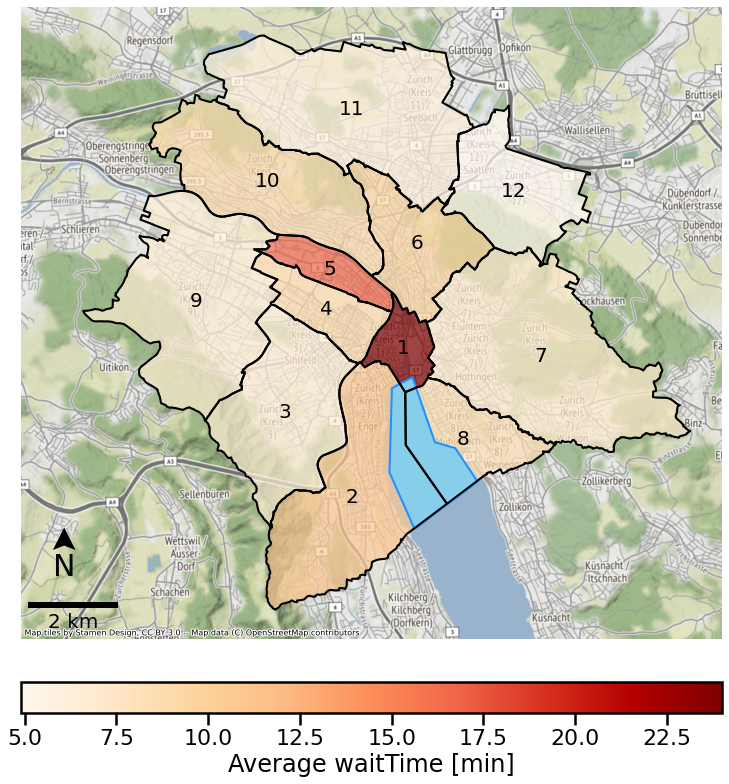

In [16]:
plotting_utils.plot_zonal_avg(district_metrics_drt_trips_stats, df_districts, 
                              'waitTime', shapely.ops.unary_union([geo for geo in df_districts["geometry"]]),
                             lake_path, zurich_districts_path, add_map=True)

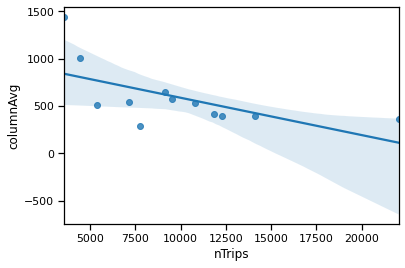

In [17]:
plotting_utils.plot_column_by_trip_density_scatter(imputed_from_trips_stats, 'district_id', 'waitTime')

# Use our grid

In [18]:
zurich_shp_path = '/cluster/work/ivt_vpl/mfrancesc/ScenarioBoundary/zurich_city_5km.shp'
zurich_shp = gpd.read_file(zurich_shp_path)

Do subplots with 5 different cell sizes

In [19]:
def plot_multigrid(grid_sizes, gpd_df):
    n_sizes = len(grid_sizes)
    plt.figure(figsize=(13,n_sizes*25))
    for idx,gs in enumerate(grid_sizes,start=0):
        plt.subplot(n_sizes*2,1,idx*2+1)
        grid = utils.create_grid_from_shapefile(zurich_shp_path, gs)
        imputed = plotting_utils.impute(gpd_df, grid, "trip_id", "grid_id",fix_by_distance=False).drop("geometry", axis=1)
        metrics = plotting_utils.get_metrics_for_zonal_plot(imputed, grid, "grid_id", metrics=["waitTime"])
        plotting_utils.plot_zonal_avg(metrics, grid, 'waitTime', 
                              zurich_shp.loc[0].geometry, lake_path, zurich_districts_path, add_map=True, in_subplot=True)
        plt.title('grid size = ' + str(gs) + 'm')
        
        plt.subplot(n_sizes*2,1,idx*2+2)
        sns.set_context('notebook')
        grouped_by_n_trips = imputed.groupby('grid_id') \
                                .agg(columnAvg=('waitTime', 'mean'), nTrips=('trip_id','size'))
        #if limit_n_trips:
        #    grouped_by_n_trips = grouped_by_n_trips[grouped_by_n_trips.nTrips < limit_n_trips]
        x = grouped_by_n_trips.nTrips
        y = grouped_by_n_trips.columnAvg
        sns.regplot(x=x,y=y)
        
        #plotting_utils.plot_column_by_trip_density_scatter(imputed_from_trips_stats, 'district_id', 'waitTime')
    plt.tight_layout()
    plt.show()


Imputing 1621  zones onto 218240  points by spatial join...


100%|██████████| 21/21 [00:01<00:00, 14.38it/s]


Imputing 429  zones onto 218240  points by spatial join...


100%|██████████| 21/21 [00:01<00:00, 14.46it/s]


Imputing 198  zones onto 218240  points by spatial join...


100%|██████████| 21/21 [00:01<00:00, 14.61it/s]


Imputing 116  zones onto 218240  points by spatial join...


100%|██████████| 21/21 [00:01<00:00, 14.29it/s]


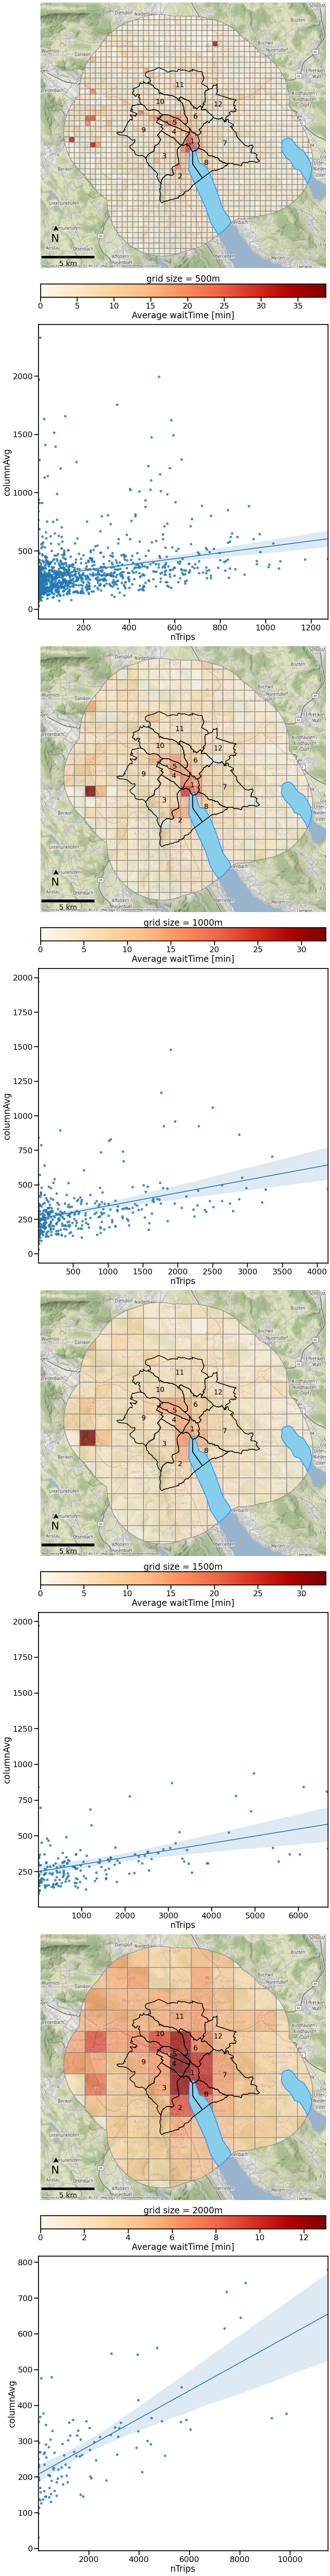

In [20]:
plot_multigrid([500,1000,1500,2000], it_drt_trips_stats_gpd)

We check the differences between using drt_legs_drt.csv and drt_trips_stats:

In [21]:
grid_2000 = utils.create_grid_from_shapefile(zurich_shp_path, 2000)

## identify zones for origin location!!
imputed_from_legs_grid_2000 = plotting_utils.impute(it_drt_legs_gpd, grid_2000, "trip_id", "grid_id",fix_by_distance=False).drop("geometry", axis=1)

grid_2000_metrics_drt_legs = plotting_utils.get_metrics_for_zonal_plot(imputed_from_legs_grid_2000, grid_2000, "grid_id", metrics=["waitTime"])#, "delayFactor", "delayFactor_estimated"])

imputed_from_trips_stats_grid_2000 = plotting_utils.impute(it_drt_trips_stats_gpd, grid_2000, "trip_id", "grid_id",fix_by_distance=False).drop("geometry", axis=1)

grid_2000_metrics_drt_trips_stats = plotting_utils.get_metrics_for_zonal_plot(imputed_from_trips_stats_grid_2000, grid_2000, "grid_id", metrics=["waitTime"])#, "delayFactor", "delayFactor_estimated"])

different = grid_2000_metrics_drt_legs.waitTime != grid_2000_metrics_drt_trips_stats.waitTime
display(grid_2000_metrics_drt_legs[different])
display(grid_2000_metrics_drt_trips_stats[different])

Imputing 116  zones onto 218240  points by spatial join...


100%|██████████| 21/21 [00:01<00:00, 14.28it/s]


Imputing 116  zones onto 218240  points by spatial join...


100%|██████████| 21/21 [00:01<00:00, 14.37it/s]


grid_id  waitTime
0       0_2       5.9
1       0_3       5.0
2       0_4       5.7
3       0_5       6.1
8      10_4       2.4
9      10_5       2.5
14     11_4       2.6
15     11_5       2.9
18     11_8       2.0
20      1_2       5.2
22      1_4       8.9
23      1_5       5.8
24      1_6       6.9
25      1_7       4.3
26      1_8       2.6
27      2_0       0.0
32      2_4       6.2
33      2_5       4.0
36      2_8       3.8
38      3_0       3.7
40     3_10       3.0
41     3_11       3.5
43      3_3       5.2
44      3_4       6.8
46      3_6       4.3
52     4_10       2.9
56      4_4       9.2
57      4_5       6.4
59      4_7       4.4
61      4_9       3.6
63      5_1       3.3
67      5_3       6.0
69      5_5      12.9
71      5_7       9.2
72      5_8       5.7
75      6_1       5.9
82      6_6      10.9
83      6_7       9.0
91      7_4       4.6
96      7_9       3.6
98      8_1       2.7
101     8_4       4.4
102     8_5       4.8
105     8_8       3.8
107     9_1       2.1
108     9_2       2.6
109     9_3       5.1
110     9_4       3.1
111     9_5       3.2
113     9_7       3.3

grid_id  waitTime
0       0_2       0.0
1       0_3       5.1
2       0_4       5.6
3       0_5       6.3
8      10_4       2.5
9      10_5       2.4
14     11_4       3.2
15     11_5       2.8
18     11_8       4.2
20      1_2       6.1
22      1_4       9.1
23      1_5       5.9
24      1_6       7.9
25      1_7       4.5
26      1_8       0.5
27      2_0       5.9
32      2_4       6.1
33      2_5       4.2
36      2_8       3.9
38      3_0       4.4
40     3_10       3.9
41     3_11       2.3
43      3_3       5.1
44      3_4       6.9
46      3_6       4.5
52     4_10       2.8
56      4_4       9.4
57      4_5       6.3
59      4_7       4.5
61      4_9       3.8
63      5_1       3.4
67      5_3       5.9
69      5_5      13.0
71      5_7       9.0
72      5_8       5.6
75      6_1       5.8
82      6_6      10.7
83      6_7       8.0
91      7_4       4.7
96      7_9       3.7
98      8_1       2.5
101     8_4       4.3
102     8_5       4.9
105     8_8       3.9
107     9_1       2.2
108     9_2       2.5
109     9_3       5.2
110     9_4       3.2
111     9_5       3.3
113     9_7       3.2

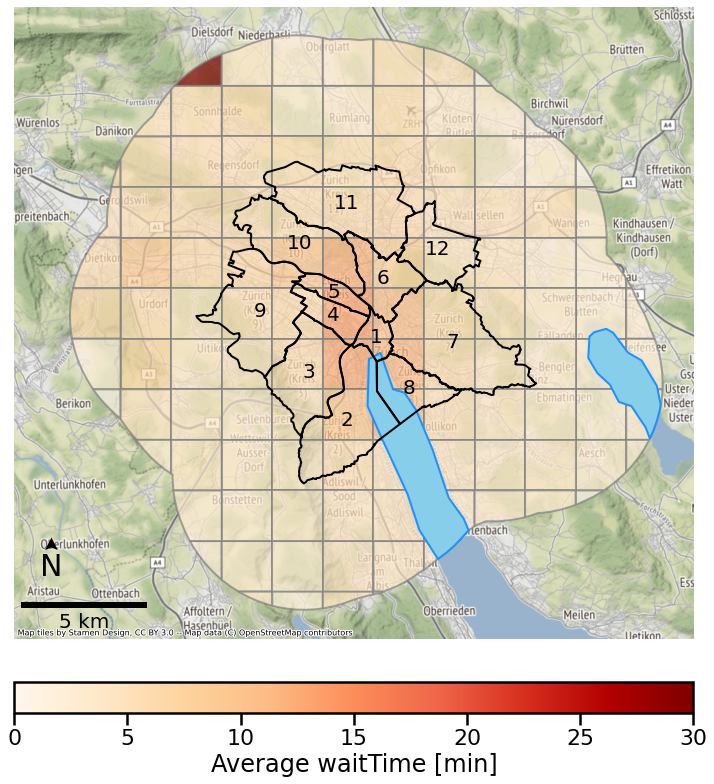

In [22]:
modified_test = grid_2000_metrics_drt_legs.copy(deep=True)
modified_test.loc[27,'waitTime'] = 30
plotting_utils.plot_zonal_avg(modified_test, grid_2000, 'waitTime', 
                              zurich_shp.loc[0].geometry, lake_path, zurich_districts_path, add_map=True)

In [23]:
display(imputed_from_legs_grid_2000[imputed_from_legs_grid_2000.grid_id == '2_0'])
display(imputed_from_trips_stats_grid_2000[imputed_from_trips_stats_grid_2000.grid_id == '2_0'])

Empty DataFrame
Columns: [departureTime, personId, vehicleId, fromLinkId, fromX, fromY, toLinkId, toX, toY, waitTime, arrivalTime, travelTime, travelDistance_m, directTravelDistance_m, fareForLeg, latestDepartureTime, latestArrivalTime, origin_geometry, destination_geometry, trip_id, grid_id]
Index: []

[0 rows x 21 columns]

personId  startTime  totalTravelTime  routerUnsharedTime  \
8497    201740009791867    42469.0            239.0             227.094   
9252    201740008022848    27639.0            230.0             201.815   
19239   201740003326232    40495.0            449.0             191.215   
26561   201740005398800    48737.0            261.0             257.044   
46599   201740004250537    19842.0            273.0             235.000   
57344   201740011015706    69767.0            178.0             155.638   
75325   201740006101758    56830.0            254.0             233.841   
81110   201740004970977    50367.0            146.0              67.000   
91963   201740007404483    42134.0            126.0              86.000   
107015  201740003341795    68361.0            259.0             103.072   
109940  201740004803896    39381.0            206.0             174.055   
129744  201740004762748    22922.0           1734.0            1124.953   
144596  201740007125033    69502.0             77.0              40.629   
171356  201740007404483    57434.0             95.0              86.000   
187277  201740004513994    29648.0             62.0              41.531   
197140  201740003089768    65295.0            155.0             123.511   
215491  201740004049359    68322.0            171.0             126.072   
217594  201740006716944    29072.0            154.0             145.926   

        estimatedUnsharedTime  delayFactor  waitTime        startX  \
8497               247.215701     1.052428     546.0  2.675904e+06   
9252               242.090227     1.139658     626.0  2.675904e+06   
19239              225.329310     2.348142     244.0  2.675904e+06   
26561              269.005994     1.015390     189.0  2.675904e+06   
46599              264.255409     1.161702     175.0  2.675594e+06   
57344              176.312577     1.143680     223.0  2.675904e+06   
75325              252.460004     1.086208     218.0  2.675904e+06   
81110              142.565707     2.179104     226.0  2.675594e+06   
91963               94.712367     1.465116     629.0  2.675594e+06   
107015             122.639432     2.512807     199.0  2.675904e+06   
109940             200.862294     1.183534     367.0  2.675594e+06   
129744            1181.942317     1.541398     174.0  2.675594e+06   
144596              74.313187     1.895198     125.0  2.675904e+06   
171356              92.741780     1.104651     135.0  2.675594e+06   
187277              59.083664     1.492861     984.0  2.675904e+06   
197140             165.232187     1.254949     269.0  2.675904e+06   
215491             170.679787     1.356368     238.0  2.675904e+06   
217594             160.842674     1.055329     812.0  2.675904e+06   

              startY          endX          endY  delayFactorEstimatedDRT  \
8497    1.257340e+06  2.675506e+06  1.256533e+06                 0.966767   
9252    1.257340e+06  2.675723e+06  1.256481e+06                 0.950059   
19239   1.257340e+06  2.675876e+06  1.256999e+06                 1.992639   
26561   1.257340e+06  2.675113e+06  1.256493e+06                 0.970239   
46599   1.257350e+06  2.675876e+06  1.256999e+06                 1.033091   
57344   1.257340e+06  2.675775e+06  1.256976e+06                 1.009571   
75325   1.257340e+06  2.675204e+06  1.256509e+06                 1.006100   
81110   1.257350e+06  2.675125e+06  1.257132e+06                 1.024089   
91963   1.257350e+06  2.675329e+06  1.257094e+06                 1.330344   
107015  1.257340e+06  2.675303e+06  1.256948e+06                 2.111882   
109940  1.257350e+06  2.675092e+06  1.256867e+06                 1.025578   
129744  1.257350e+06  2.680903e+06  1.251556e+06                 1.467077   
144596  1.257340e+06  2.675590e+06  1.257111e+06                 1.036155   
171356  1.257350e+06  2.675329e+06  1.257094e+06                 1.024350   
187277  1.257340e+06  2.675601e+06  1.257072e+06                 1.049359   
197140  1.257340e+06  2.67

# OD for delayFactor

In [24]:
it_drt_trips_stats_gpd.head()

personId  startTime  totalTravelTime  routerUnsharedTime  \
0  201740004636244    62019.0             89.0              81.515   
1  201740008568862    65671.0           1475.0             937.631   
2  201740011111262    76053.0           5115.0            1022.628   
3  201740004701204    57834.0           1401.0             666.957   
4  201740011924315    25615.0            421.0             222.409   

   estimatedUnsharedTime  delayFactor  waitTime        startX        startY  \
0              94.418002     1.091824     193.0  2.681824e+06  1.259072e+06   
1            1362.749856     1.573114     902.0  2.683445e+06  1.252980e+06   
2            1980.019313     5.001819     871.0  2.682604e+06  1.248563e+06   
3            1016.692096     2.100585     159.0  2.683417e+06  1.250534e+06   
4             246.885588     1.892909     107.0  2.683472e+06  1.253408e+06   

           endX          endY  delayFactorEstimatedDRT  \
0  2.681242e+06  1.258825e+06                 0.942617   
1  2.678790e+06  1.251416e+06                 1.082370   
2  2.675778e+06  1.250827e+06                 2.583308   
3  2.679568e+06  1.246854e+06                 1.377998   
4  2.683430e+06  1.252254e+06                 1.705243   

                                 origin_geometry  \
0  POINT (2681824.2592736883 1259072.2878148262)   
1   POINT (2683445.038287379 1252979.8265686487)   
2  POINT (2682603.8198432215 1248562.7515384508)   
3    POINT (2683417.374883772 1250533.965794745)   
4    POINT (2683471.550439642 1253408.377541923)   

                            destination_geometry  \
0    POINT (2681241.9761702064 1258825.45616673)   
1    POINT (2678789.53038175 1251415.5538315158)   
2   POINT (2675778.2623087317 1250827.274414047)   
3  POINT (2679568.1707531633 1246854.4118580215)   
4  POINT (2683430.2868011305 1252254.1171945822)   

                          geometry  trip_id  
0  POINT (2681824.259 1259072.288)        1  
1  POINT (2683445.038 1252979.827)        2  
2  POINT (2682603.820 1248562.752)        3  
3  POINT (2683417.375 1250533.966)        4  
4  POINT (2683471.550 1253408.378)        5

In [25]:
imputed_from_trips_stats = plotting_utils.impute(it_drt_trips_stats_gpd, df_districts, "trip_id", "district_id",fix_by_distance=False).drop("geometry", axis=1)
imputed_from_trips_stats['geometry'] = imputed_from_trips_stats['destination_geometry']
imputed_from_trips_stats = imputed_from_trips_stats.rename(columns={'district_id': 'origin_district_id'})
imputed_from_trips_stats = gpd.GeoDataFrame(imputed_from_trips_stats)
imputed_from_trips_stats.crs = "epsg:2056"
imputed_from_trips_stats = plotting_utils.impute(imputed_from_trips_stats, df_districts, "trip_id", "district_id",fix_by_distance=False).drop("geometry", axis=1)
imputed_from_trips_stats = imputed_from_trips_stats.rename(columns={'district_id': 'destination_district_id'})

#imputed_from_trips_stats['OD_district'] = imputed_from_trips_stats['origin_district_id'].astype('str') + '-' + imputed_from_trips_stats['destination_district_id'].astype('str')


Imputing 12  zones onto 218240  points by spatial join...


100%|██████████| 21/21 [00:01<00:00, 14.06it/s]


Imputing 12  zones onto 218240  points by spatial join...


100%|██████████| 21/21 [00:01<00:00, 14.25it/s]


In [26]:
def plot_OD_delayFactor_heatmaps(imputed):
    filtered_imputed = imputed[imputed.routerUnsharedTime != 0].copy()
    group_by = filtered_imputed.groupby(['origin_district_id', 'destination_district_id'])
    average_df_router = group_by.delayFactor.mean().unstack()
    average_df_estimated = group_by.delayFactorEstimatedDRT.mean().unstack()
    computed_df_router = (group_by.totalTravelTime.sum() / group_by.routerUnsharedTime.sum()).unstack()
    computed_df_estimated = (group_by.totalTravelTime.sum() / group_by.estimatedUnsharedTime.sum()).unstack()
    
    to_plot = [average_df_router, average_df_estimated, computed_df_router, computed_df_estimated]
    titles = ['Avg of DF using router', 'Avg of DF using estimation from DRT', 'Computed DF from sum using router', 'Computed DF from sum estimation from DRT']
    
    fig = plt.figure(figsize=(20,20))
    
    for idx, data in enumerate(to_plot, start=1):
        ax = plt.subplot(2,2,idx)
        im = ax.matshow(data.values)

    # Show all ticks and label them with the respective list entries
        #display(data)
        plt.xticks(np.arange(len(data.columns)), labels=data.columns.values.astype('int'))
        plt.yticks(np.arange(len(data.index)), labels=data.index.values.astype('int'))
        plt.xlabel(data.columns.name)
        plt.ylabel(data.index.name)
        ax.xaxis.set_ticks_position('bottom')
        plt.title(titles[idx-1])
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel('delayFactor', rotation=-90, va="bottom")
    plt.tight_layout()
    plt.show()

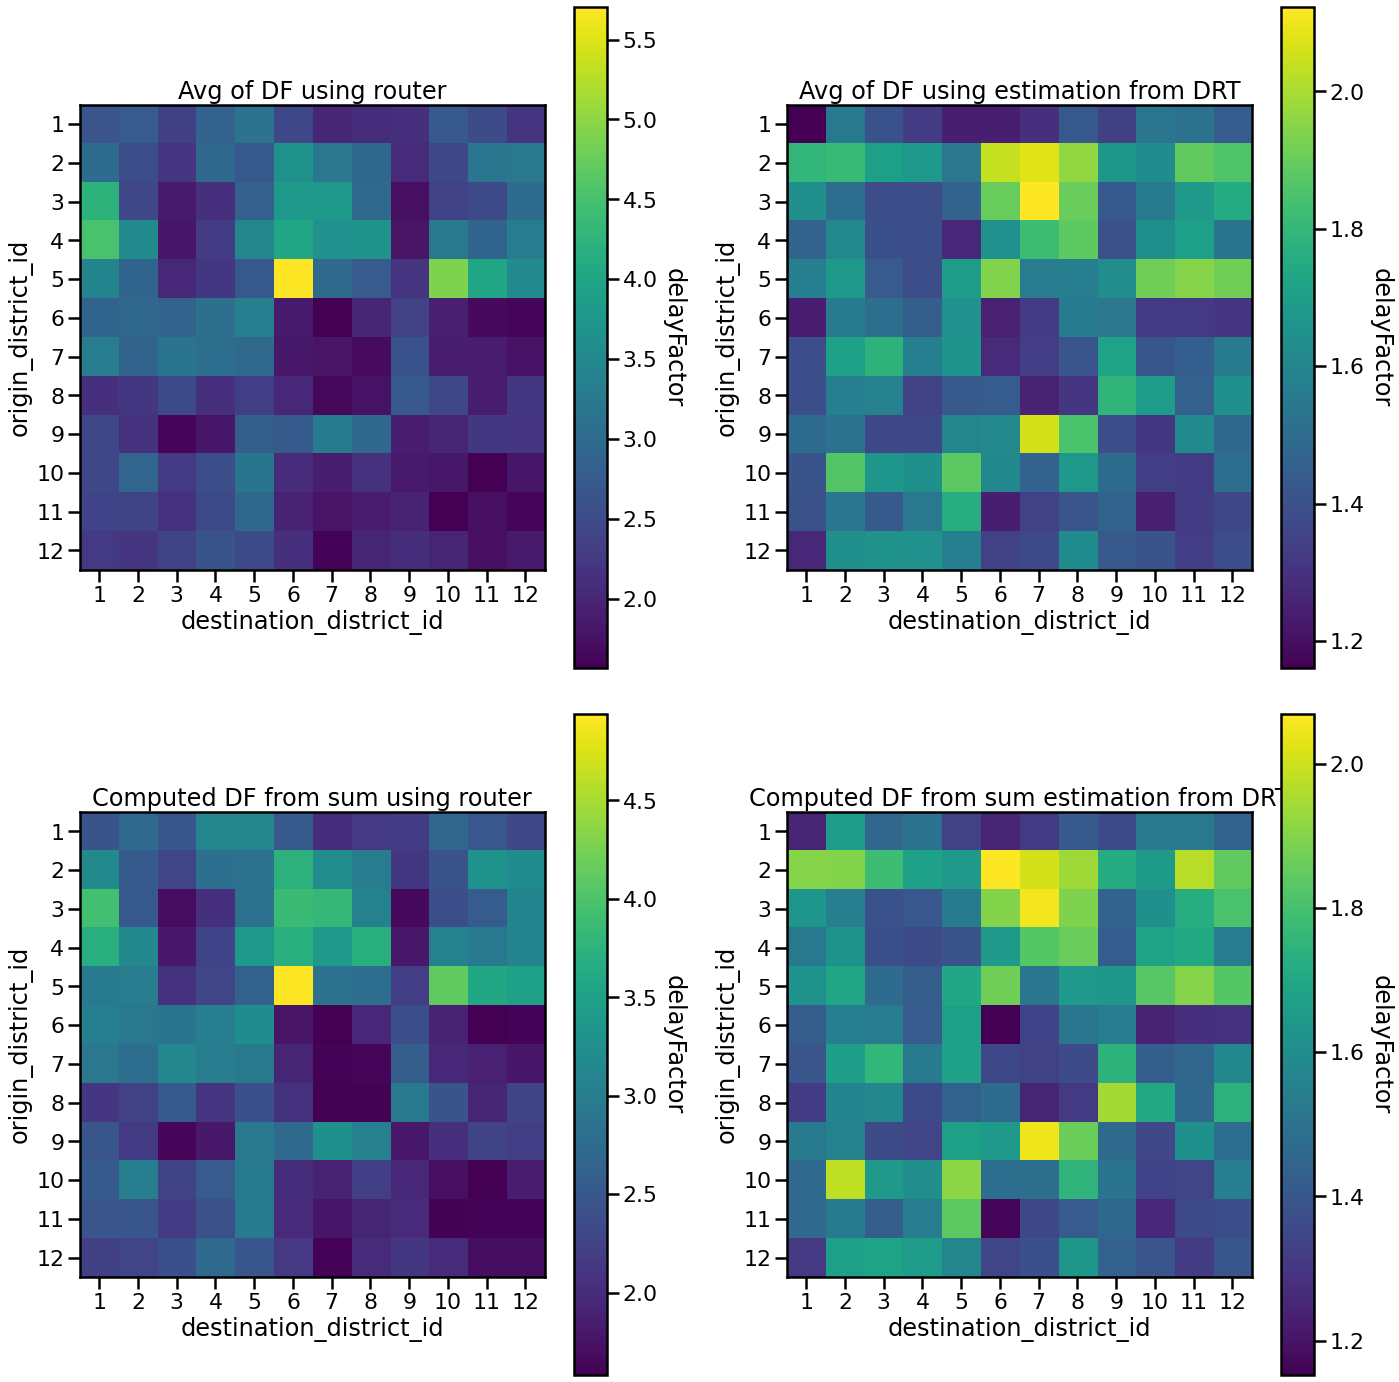

In [27]:
plot_OD_delayFactor_heatmaps(imputed_from_trips_stats)

In [28]:
imputed_from_trips_stats[['origin_district_id','destination_district_id']].value_counts().sort_index().unstack()

destination_district_id  1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   \
origin_district_id                                                              
1.0                       845   315   427   292    95   165   511   128   119   
2.0                       308  5587   795   178    53    68   327   339   190   
3.0                       310   672  6975  1587   226    96   204    89  1156   
4.0                       208   194  1722  3048   489   103    92    38   729   
5.0                        64    65   331   703  1585   240    55    27   506   
6.0                       164    55   237   268   390  4420   516    78   181   
7.0                       336   250   179   116    97   521  7139  1130    74   
8.0                        94   229    75    49    42    64  1122  2410    26   
9.0                        76   168  1103   685   419   120    66    52  8818   
10.0                       67    62   162   194   486   858    91    47   761   
11.0                       96    62   112   134   157   953   170    57   326   
12.0                       40    25    69    61    70   277    91    24    69   

destination_district_id  10.0   11.0  12.0  
origin_district_id                          
1.0                        62    117    47  
2.0                        33     50    26  
3.0                        91     98    49  
4.0                        91     56    28  
5.0                       294    147    69  
6.0                       789   1176   418  
7.0                       104    169   136  
8.0                        39     70    28  
9.0                       627    276    42  
10.0                     4832   1243   158  
11.0                     1109  13711  1082  
12.0                      128   1017  3706